In [1]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

def bit_compare():
    qr = QuantumRegister(2, "bits")
    aux = QuantumRegister(2, "aux")
    
    qc = QuantumCircuit(qr, aux)
    qc.x(qr[1])
    qc.mcx(qr, aux[0])
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr, aux[1])
    qc.x(qr[0])
    
    return qc

In [3]:
print(bit_compare())

                  ┌───┐     ┌───┐
bits_0: ───────■──┤ X ├──■──┤ X ├
        ┌───┐  │  ├───┤  │  └───┘
bits_1: ┤ X ├──■──┤ X ├──■───────
        └───┘┌─┴─┐└───┘  │       
 aux_0: ─────┤ X ├───────┼───────
             └───┘     ┌─┴─┐     
 aux_1: ───────────────┤ X ├─────
                       └───┘     


In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

def inverse_bit_compare():
    qr = QuantumRegister(2, "bits")
    aux = QuantumRegister(2, "aux")
    
    qc = QuantumCircuit(qr, aux)
    
    qc.x(qr[0])
    qc.mcx(qr, aux[1])
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr, aux[0])
    qc.x(qr[1])
    
    return qc

In [5]:
print(inverse_bit_compare())

        ┌───┐     ┌───┐          
bits_0: ┤ X ├──■──┤ X ├──■───────
        └───┘  │  ├───┤  │  ┌───┐
bits_1: ───────■──┤ X ├──■──┤ X ├
               │  └───┘┌─┴─┐└───┘
 aux_0: ───────┼───────┤ X ├─────
             ┌─┴─┐     └───┘     
 aux_1: ─────┤ X ├───────────────
             └───┘               


In [6]:
def encode(bit):
    qr = QuantumRegister(1, "number")
    qc = QuantumCircuit(qr)
    if (bit == "1"):
        qc.x(qr[0])
    return qc

In [7]:
def compare_bitstring(bitstring_a, bitstring_b):
    bits = len(bitstring_a)
    qra = QuantumRegister(bits, "a")
    qrb = QuantumRegister(bits, "b")
    qraux = QuantumRegister(2*bits, "aux")
    qrint = QuantumRegister(bits-1, "int")
    qrmin = QuantumRegister(1,"min")
    cr = ClassicalRegister(4)

    qc = QuantumCircuit(qra, qrb, qraux, qrint, qrmin, cr)
    
    #hadamard
    for i in range(bits):
        qc.h([qrb[i]])
        
    qc.x(qrmin[0])
    qc.h(qrmin[0])

    for i in range(bits):
        qc.append(encode(bitstring_a[i]), [qra[i]])
        #qc.append(encode(bitstring_b[i]), [qrb[i]])
        qc.append(bit_compare(), [qra[i], qrb[i], qraux[2*i], qraux[2*i+1]])
                
        if i < bits-1:
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
            qc.mcx([qraux[2*i], qraux[2*i+1]], qrint[i])
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
    
   
    qc.mcx([qraux[4],  qrint[1]], qraux[2])
    qc.mcx([qraux[5],  qrint[1]], qraux[3])
    qc.mcx([qraux[2],  qrint[0]], qraux[0])
    qc.mcx([qraux[3],  qrint[0]], qraux[1])    
    
    qc.barrier()
    #min control
   
    qc.cx(qraux[1],qrmin[0])
        
    qc.barrier() 
    
    #Inverse circuit  
    qc.mcx([qraux[3],  qrint[0]], qraux[1]) 
    qc.mcx([qraux[2],  qrint[0]], qraux[0])   

    qc.mcx([qraux[5],  qrint[1]], qraux[3])
    qc.mcx([qraux[4],  qrint[1]], qraux[2])
    
    for i in range(bits):
        if i < bits-1:
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
            qc.mcx([qraux[2*i], qraux[2*i+1]], qrint[i])
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])   

    
    qc.barrier()
    for i in reversed(range(bits)):
        qc.append(inverse_bit_compare(), [qra[i], qrb[i], qraux[2*i], qraux[2*i+1]])
        
    qc.barrier()
    
    #diffuser
    for i in range(bits-1):
        qc.h(qrb[i])
        qc.x(qrb[i])
    
    qc.h(qrb[2])
    qc.x(qrb[2])
    qc.h(qrb[2])
    qc.mcx([qrb[0], qrb[1]], qrb[2])
    qc.h(qrb[2])
    qc.x(qrb[2])
    qc.h(qrb[2])
    
    
    for i in range(bits-1):
        qc.x(qrb[i])
        qc.h(qrb[i])   

    
    #measure
    qc.measure(qrb[0], cr[2])
    qc.measure(qrb[1], cr[1])
    qc.measure(qrb[2], cr[0])
   
           
    return qc

In [24]:
bitstring_a = "101"
bitstring_b = "000"

In [25]:
circuit = compare_bitstring(bitstring_a, bitstring_b)

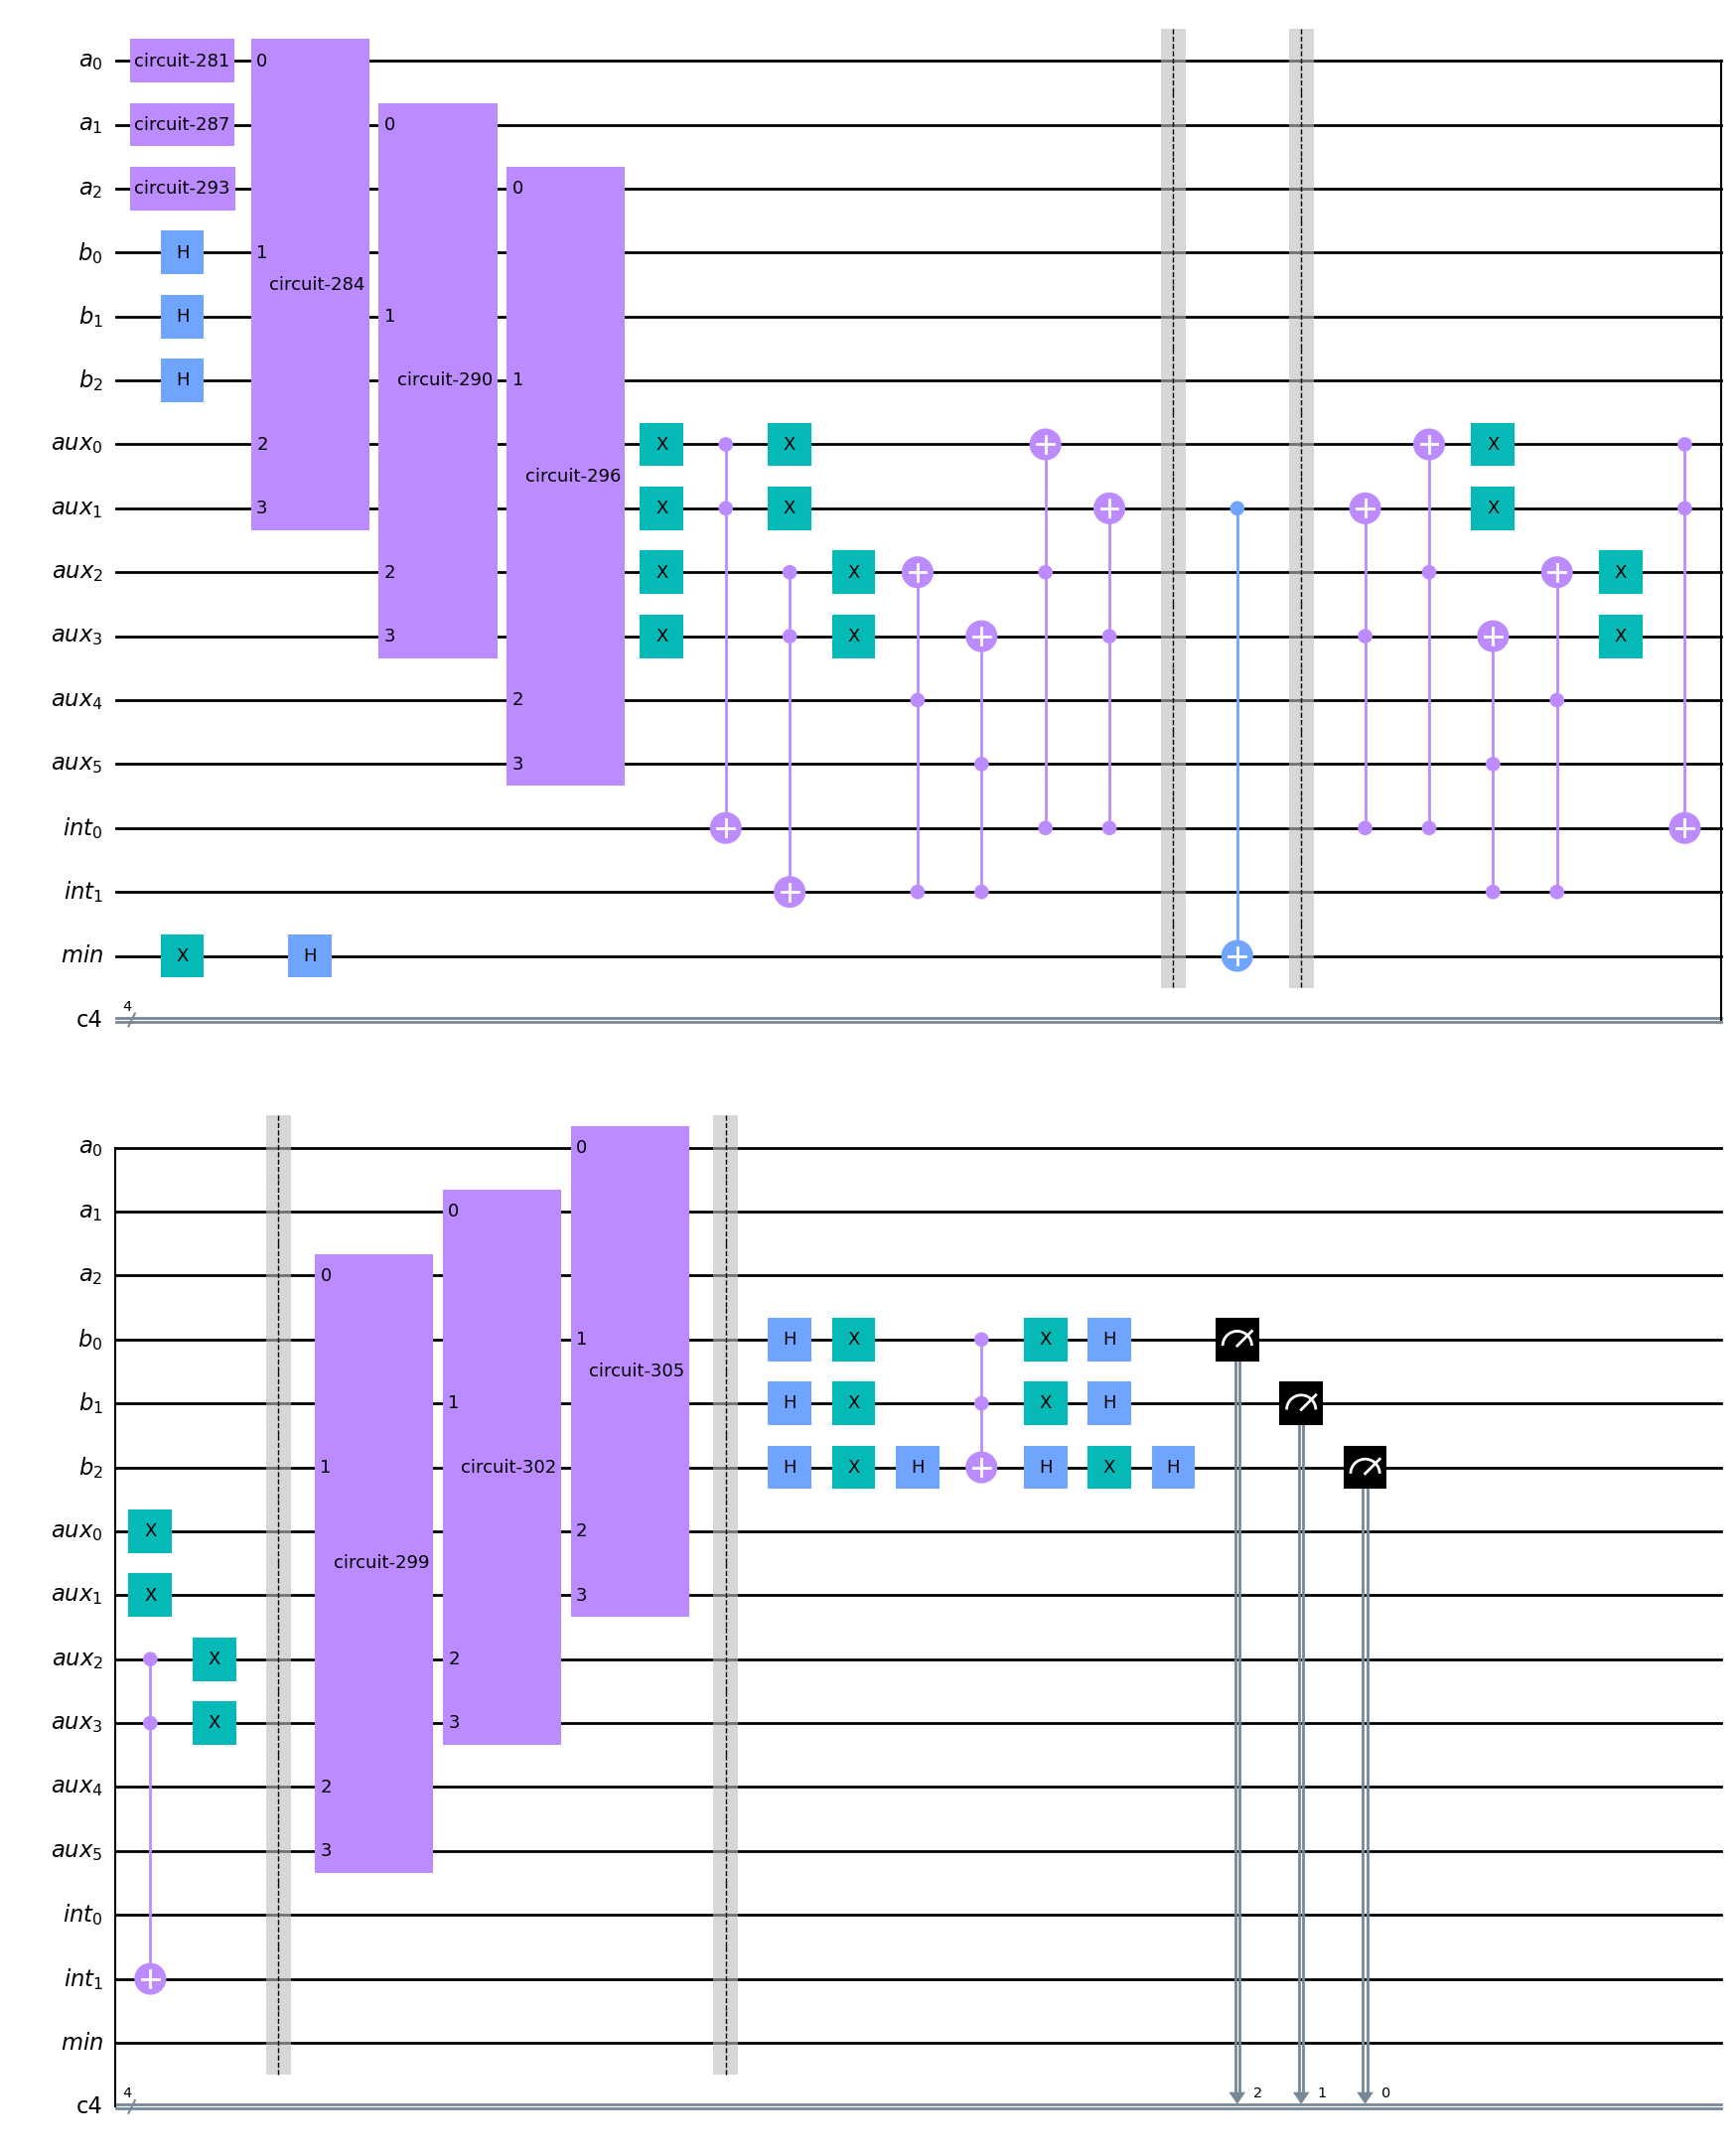

In [26]:
# Draw the circuit
circuit.draw(output='mpl')

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
service = QiskitRuntimeService()
#backend = service.backend("ibmq_qasm_simulator")
backend = service.get_backend("simulator_statevector")
pm = generate_preset_pass_manager(optimization_level=1, target=backend.target) 
isa_circuits = pm.run(circuit)
job = Sampler(backend).run(isa_circuits)
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: co9fgrjl9hecuf50qhg0
SamplerResult(quasi_dists=[{7: 0.48225, 6: 0.51775}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])
